In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from IPython import display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
data=pd.read_csv('mnist_train.csv')


In [3]:
rand=np.random.randint(0,data.shape[0],20000)
data=data.iloc[rand,:].reset_index()
data.drop(columns='index',inplace=True)
data


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
labels=data.iloc[:,0]
data=data.drop(columns='label',axis=1)
print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


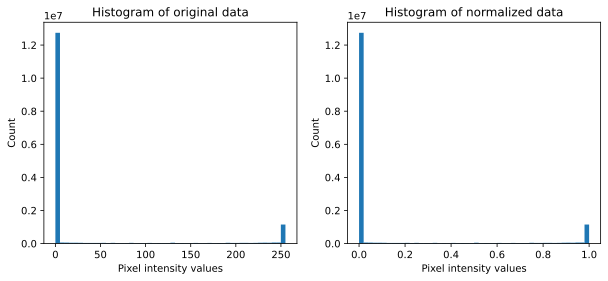

In [5]:
dataNorm = data/np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.values.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.values.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

In [6]:
dataT   = torch.tensor( dataNorm.values ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
     

In [7]:
def createTheMnistNet(optimizerAlgo,learningrate):

    class ANNmnist(nn.Module):
        def __init__(self):
            super().__init__()

      ### input layer
            self.input = nn.Linear(784,64)
      
      ### hidden layer
            self.fc1 = nn.Linear(64,64)
            self.fc2=nn.Linear(64,32)

      ### output layer
            self.output = nn.Linear(32,10)

    # forward pass
        def forward(self,x):
            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            x = F.relu( self.fc2(x) )
            
            return self.output(x)
  
  # create the model instance
    net = ANNmnist()
  
      # loss function
    lossfun = nn.CrossEntropyLoss()
     # optimizer
    optifun = getattr( torch.optim,optimizerAlgo )
    optimizer = optifun(net.parameters(),lr=learningrate)

    return net,lossfun,optimizer


In [8]:
def function2trainTheModel(optimizerType,learningrate):

  # number of epochs
    numepochs = 50
  
      # create a new model
    net,lossfun,optimizer = createTheMnistNet(optimizerType,learningrate)

      # initialize losses
    losses   = np.zeros(numepochs)
    trainAcc = []
    testAcc  = []

      # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        net.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

              # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

              # loss from this batch
            batchLoss.append(loss.item())

              # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
      # end epochs

      # function output
    return trainAcc,testAcc,losses,net

In [ ]:
# variables to loop over
learningRates = np.logspace(np.log10(.0001),np.log10(.1),6)
optimTypes = ['SGD','RMSprop','Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(learningRates),len(optimTypes)))


# now for the experiment!
for idx_o,opto in enumerate(optimTypes):
    for idx_l,lr in enumerate(learningRates):
        trainAcc,testAcc,losses,net = function2trainTheModel(opto,lr)
        finalPerformance[idx_l,idx_o] = np.mean(testAcc[-10:])
     

In [ ]:
plt.plot(learningRates,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()
     